In [1]:
import nibabel as nib #to read the niftis
from glob import glob #to quicly read the nifti paths
import logging # for printing monai info
import sys # for printing monai info
import monai #for this experiment monai will be the main framework for 2d segmentation
import torch
from monai.transforms import (
    Activations,
    Activationsd,
    AddChannel,
    AsDiscrete,
    AsDiscreted,
    AsChannelFirst,
    Compose,
    ConvertToMultiChannelBasedOnBratsClassesd,
    Invertd,
    LoadImaged,
    LabelToMask,
    LoadImage,
    MapTransform,
    NormalizeIntensity,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    RandSpatialCrop,
    Resize,
    RandFlip,
    RandRotate,
    Spacing,
    Spacingd,
    ScaleIntensity, 
    SpatialCrop,
    ToTensor,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Resized
)
from torch.utils.tensorboard import SummaryWriter

from monai.data import (
    ArrayDataset, GridPatchDataset, create_test_image_3d, PatchIter) #Aparently this allow to read direcly a set of niftis
from monai.utils import first
from matplotlib import pyplot as plt
from monai.metrics import DiceMetric

import numpy as np

#from img2vec_pytorch import Img2Vec
from PIL import Image
from matplotlib import cm
from torch import nn
import torch.nn.functional as F
from natsort import natsorted
from monai.networks.nets import AHNet, DenseNet121
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter
print(monai.__version__) 
monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)



0.8.0
MONAI version: 0.8.0
Numpy version: 1.21.2
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: 0.4.7
Nibabel version: 3.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 8.4.0
Tensorboard version: 2.7.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.1
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
LIEU = 'sebastian_insel'

if LIEU=='sebastian_insel':
    root_exp  = '/home/sebastian/experiments/fedem/'
    root_data = '/media/sebastian/data/ASAP/BRATS_2019_ubelix/center_wise/'
    brats_nifti__dir_paths = natsorted(glob(root_data+"**/**/"))

if LIEU=='sebastian_laptop':
    root_exp  = '/Users/sebastianotalora/work/postdoc/federated_learning/fedem/'
    root_data = '/Users/sebastianotalora/work/postdoc/federated_learning/data/'
    brats_nifti__dir_paths = natsorted(glob(root_data+'brats/'"**/**/"))
len(brats_nifti__dir_paths)#Should be 259

259

In [3]:
EXP_TYPE = 'CENTRALIZED' #FEDERATED
if EXP_TYPE == 'FEDERATED':
    print("To Implement")
if EXP_TYPE == 'CENTRALIZED':
    train_ids = tuple(open(root_exp+'data/partitions/brats_centralized_train.txt').read().split('\n'))
    val_ids = tuple(open(root_exp+'data/partitions/brats_centralized_validation.txt').read().split('\n'))
    test_ids = tuple(open(root_exp+'data/partitions/brats_centralized_test.txt').read().split('\n'))

In [4]:
imtrans = Compose(
    [   LoadImage(image_only=True),
         Spacing(
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear"),
            image_only = True,
        ),
        #ScaleIntensity(),
        #NormalizeIntensity(nonzero=True, channel_wise=True),
        AsChannelFirst(),
        ToTensor(),
        #AddChannel(),
        #EnsureType(),
        #Resized,
        #RandFlip(prob=0.5, spatial_axis=0),
        RandRotate(),
        NormalizeIntensity(nonzero=True, channel_wise=True),
        Resize(spatial_size=(112,112,72))
    ]
)

segtrans = Compose(
    [   LoadImage(image_only=True),
        #AsChannelFirst(),
        ToTensor(),
        AddChannel(),
        #ConvertLabelBrats(keys=(1,2,4)),
         #EnsureType(),
        #Resized,
        Resize(spatial_size=(112,112,72),mode='nearest')
    ]
)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
count_saving = 0
train_volumes_paths, train_labels_paths = [],[]
validation_volumes_paths, validation_labels_paths = [],[]
test_volumes_paths, test_labels_paths = [],[]

for item in brats_nifti__dir_paths:
    if item.split('/')[-2] in set(train_ids):
        train_volumes_paths.append(item+"stacked.nii.gz")
        train_labels_paths.append(item+"gt.nii.gz")
    if item.split('/')[-2] in set(val_ids):
        validation_volumes_paths.append(item+"stacked.nii.gz")
        validation_labels_paths.append(item+"gt.nii.gz")
    if item.split('/')[-2] in set(test_ids):
        test_volumes_paths.append(item+"stacked.nii.gz")
        test_labels_paths.append(item+"gt.nii.gz")

In [7]:
train_ds    = ArrayDataset(train_volumes_paths, imtrans, train_labels_paths, segtrans)
validation_ds    = ArrayDataset(validation_volumes_paths, imtrans, validation_labels_paths, segtrans)
test_ds    = ArrayDataset(test_volumes_paths, imtrans, test_labels_paths, segtrans)

In [8]:
embedding_model = DenseNet121(pretrained=True, spatial_dims = 2, in_channels=4,out_channels = 1)

In [9]:
vol_example = train_ds[0][0]
print(vol_example.shape)

torch.Size([4, 112, 112, 72])


In [10]:
embedding_model(vol_example[np.newaxis,:,:,:,0])

tensor([[0.0549]], grad_fn=<AddmmBackward0>)

In [14]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
embedding_model.features.denseblock4.register_forward_hook(get_activation('norm5'))

In [15]:
embedding_model.features

Sequential(
  (conv0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (layers): Sequential(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (denselayer2): _DenseLayer(
      (layers): Sequential(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
embedding_model.

In [16]:
activation.keys()

dict_keys([])

In [17]:
vol_example[np.newaxis,:,:,:,0].shape

torch.Size([1, 4, 112, 112])

In [38]:
slice_embeddings[0].shape

torch.Size([1, 1024, 3, 3])

In [42]:
.shape

(1024,)

In [31]:
np.average(np.average(slice_embeddings[0][0]))

-0.013260848

In [45]:
sample = vol_example

slice_embeddings = []

for i in range(sample.shape[-1]):#Loop over all the slices
    cur_slice  = sample[np.newaxis,:,:,:,i]
    cur_output = embedding_model(cur_slice)[0]    
    slice_embeddings.append(np.average(np.average(activation['norm5'],axis=2),axis=2)[0])
slice_embeddings = torch.tensor(np.array(slice_embeddings))

In [46]:
slice_embeddings.shape

torch.Size([72, 1024])

In [18]:
output = embedding_model(vol_example[np.newaxis,:,:,:,0])
print(activation['norm5'])
activation['norm5'].shape


tensor([[[[-0.0686,  0.0657, -0.0989],
          [ 0.0220, -0.0564, -0.2770],
          [-0.0154, -0.0357, -0.1947]],

         [[-0.0475, -0.0159,  0.0425],
          [-0.0304, -0.0400, -0.1517],
          [-0.0581, -0.0462, -0.0739]],

         [[-0.2107, -0.0361, -0.1833],
          [-0.0188, -0.0347, -0.1666],
          [ 0.0647,  0.0718,  0.0907]],

         ...,

         [[ 0.0122,  0.0308,  0.0351],
          [ 0.0182,  0.0351,  0.0377],
          [ 0.0203,  0.0331,  0.0259]],

         [[ 0.0066,  0.0045,  0.0022],
          [ 0.0033, -0.0083, -0.0003],
          [ 0.0068, -0.0034,  0.0066]],

         [[-0.0058,  0.0176,  0.0166],
          [-0.0023,  0.0078,  0.0145],
          [ 0.0009, -0.0076, -0.0125]]]])


torch.Size([1, 1024, 3, 3])

In [56]:
def get_2D_embedding(input_img, model):
    return_layers = {'denselayer16': 'denselayer16'}
    mid_getter = MidGetter(model, return_layers=return_layers, keep_output=True)
    mid_outputs, model_output = mid_getter(input_img)
    embedding = mid_outputs['denselayer16']
    #pvol_shape = Pvol.shape
    #Pvol = model.softmax3d(Pvol.flatten())
    #Pvol = Pvol.reshape(pvol_shape)
    return embedding

In [57]:
get_2D_embedding(vol_example[np.newaxis,:,:,:,0], embedding_model)

AttributeError: 'DenseNet121' object has no attribute 'denselayer16'

In [4]:
isles_data_root = '/Users/sebastianotalora/work/postdoc/data/ISLES/TRAINING/'

In [5]:
cbf_paths = sorted(glob(isles_data_root+'*/*CBF*/*nii'))
cbv_paths = sorted(glob(isles_data_root+'*/*CBV*/*nii'))
mtt_paths = sorted(glob(isles_data_root+'*/*MTT*/*nii'))
tmx_paths = sorted(glob(isles_data_root+'*/*Tmax*/*nii'))
lbl_paths = sorted(glob(isles_data_root+'*/*OT*/*nii'))
print(cbf_paths[-1])

IndexError: list index out of range

In [5]:
imtrans = Compose(
    [   LoadImage(image_only=True),
        ScaleIntensity(),
        AddChannel(),
        RandSpatialCrop((224, 224,1), random_size=False),
        EnsureType(),
        #Resized
    ]
)

segtrans = Compose(
    [   LoadImage(image_only=True),
        AddChannel(),
        RandSpatialCrop((224, 224,1), random_size=False),
        EnsureType(),
        #Resized
    ]
)

In [7]:
ds = ArrayDataset(cbf_paths, imtrans, lbl_paths, segtrans)

In [8]:
loader = torch.utils.data.DataLoader(
    ds, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)
im, seg = first(loader)
print(im.shape, seg.shape)

torch.Size([1, 1, 224, 224, 1]) torch.Size([1, 1, 224, 224, 1])


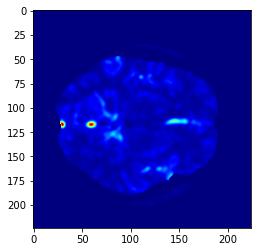

In [9]:
sample_im, sample_seg = im.numpy(), seg.numpy()
plt.imshow(sample_im[0,0,:,:,0],cmap='jet')

In [31]:
sample_im[0,0,:,:,0].shape

(224, 224)

In [27]:
im = Image.fromarray(np.uint8(cm.gist_earth(sample_im[0,0,:,:,0])*255))

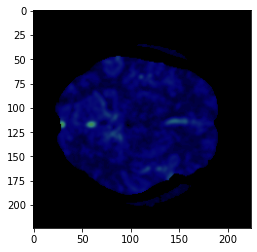

In [28]:
plt.imshow(im)

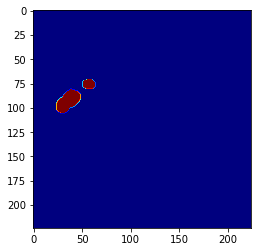

In [10]:
plt.imshow(sample_seg[0,0,:,:,0],cmap='jet')

In [29]:
# Initialize Img2Vec with GPU
img2vec = Img2Vec(cuda=False)


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [30]:
vec = img2vec.get_vec(im, tensor=True)

RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0